Comenzamos importando librerías

Dataset: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art/data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import os
from PIL import Image
from zipfile import ZipFile
from IPython.display import Image

Para empezar debemos cargar el dataset desde kaggle:
- pixel-art.zip

Para ello subiremos nuestras credenciales de Kaggle e importaremos el dataset desde nuestra cuenta. Las credenciales deben ser un archivo:
- kaggle.json

In [ ]:
from google.colab import files
uploaded = files.upload() # Subir kaggle.json

# Reubicar el archivo
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Establecer permisos correctos

# Descargar el dataset desde kaggle
!kaggle datasets download -d ebrahimelgazar/pixel-art

# Descomprimir el dataset descargado
with ZipFile("pixel-art.zip", 'r') as zip_ref:
  zip_ref.extract("sprites.npy", "./")
  zip_ref.extract("sprites_labels.npy", "./")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
 89% 76.0M/85.7M [00:01<00:00, 99.3MB/s]
100% 85.7M/85.7M [00:01<00:00, 83.2MB/s]


Cargamos las entradas y los labels y los observamos

In [ ]:
data = np.load('sprites.npy')
labels = np.load('sprites_labels.npy')

print("Tamaño de los datos:", data.shape)
print("Tamaño de las etiquetas:", labels.shape)

print(data[0])
print(labels[0])


Tamaño de los datos: (89400, 16, 16, 3)
Tamaño de las etiquetas: (89400, 5)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [ 99  27  79]
  [247  67 198]
  [172  47 138]
  [172  47 138]
  [247  67 198]
  [ 99  27  79]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [ 99  27  79]
  [247  67 198]
  [172  47 138]
  [172  47 138]
  [172  47 138]
  [172  47 138]
  [247  67 198]
  [ 99  27  79]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [ 99  27  79]
  [172  47 138]
  [172  47 138]
  [ 74  20  59]
  [ 74  20  59]
  [ 74  20  59]
  [ 74  20  59]
  [172  47 138]
  [172  47 138]
  [ 99  27  79]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [ 99  27  79]
  [172  47 138]
  [ 74  20  59]
  [ 74  20  59]
  [ 99  27  79]
  [ 99  27  79]
  [ 74

Ahora ya podemos comenzar el proceso de formateo del dataset:

- Normalizer: Se han normalizado los valores de los píxeles entre 0 y 1, dividiendo por 255 para que la red neuronal funcione mejor durante el entrenamiento.
- LabelBinarizer: Las etiquetas se convierten en formato binario utilizando LabelBinarizer para ajustarse al formato de salida de la red neuronal.


In [ ]:
# Normalizar los datos de las imágenes (valores entre 0 y 1)
dataF = data.astype('float32') / 255.0

# Binarize labels
lb = LabelBinarizer()
labelsF = lb.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(dataF, labelsF, test_size=0.5)


print(dataF[0])
print(labelsF[0])

[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.3882353  0.10588235 0.30980393]
  [0.96862745 0.2627451  0.7764706 ]
  [0.6745098  0.18431373 0.5411765 ]
  [0.6745098  0.18431373 0.5411765 ]
  [0.96862745 0.2627451  0.7764706 ]
  [0.3882353  0.10588235 0.30980393]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.3882353  0.10588235 0.30980393]
  [0.96862745 0.2627451  0.7764706 ]
  [0.6745098  0.18431373 0.5411765 ]
  [0.6745098  0.18431373 0.5411765 ]
  [0.6745098  0.18431373 0.5411765 ]
  [0.6745098  0.18431373 0.5411765 ]
  [0.96862745 0.2627451  0.7764706 ]

In [ ]:
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print(X_train.shape)
print(y_train.shape)
print("Tamaño del conjunto de prueba:", len(X_test))
print(X_test.shape)
print(y_test.shape)

Tamaño del conjunto de entrenamiento: 44700
(44700, 16, 16, 3)
(44700, 5)
Tamaño del conjunto de prueba: 44700
(44700, 16, 16, 3)
(44700, 5)


Ahora sí, construimos la red CNN:

1. Capas Convolucionales: Se utilizan varias capas convolucionales con funciones de activación ReLU para extraer características relevantes de las imágenes.
2. Pooling: Después de cada capa convolucional, se utiliza MaxPooling para reducir la dimensionalidad, mejorando la eficiencia computacional sin perder características importantes.
3. Aplanado (Flatten): Se aplanan los mapas de características 2D a un vector 1D para poder conectarlo a capas densas.
4. Capa Densa: Una capa densa oculta proporciona la capacidad de aprender relaciones complejas.
5. Dropout: La capa de dropout previene el overfitting.
6. Capa de Salida: la capa de salida utiliza softmax para la clasificación multicategoría.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,933 (206.77 KB)

 Trainable params: 52,933 (206.77 KB)

 Non-trainable params: 0 (0.00 B)

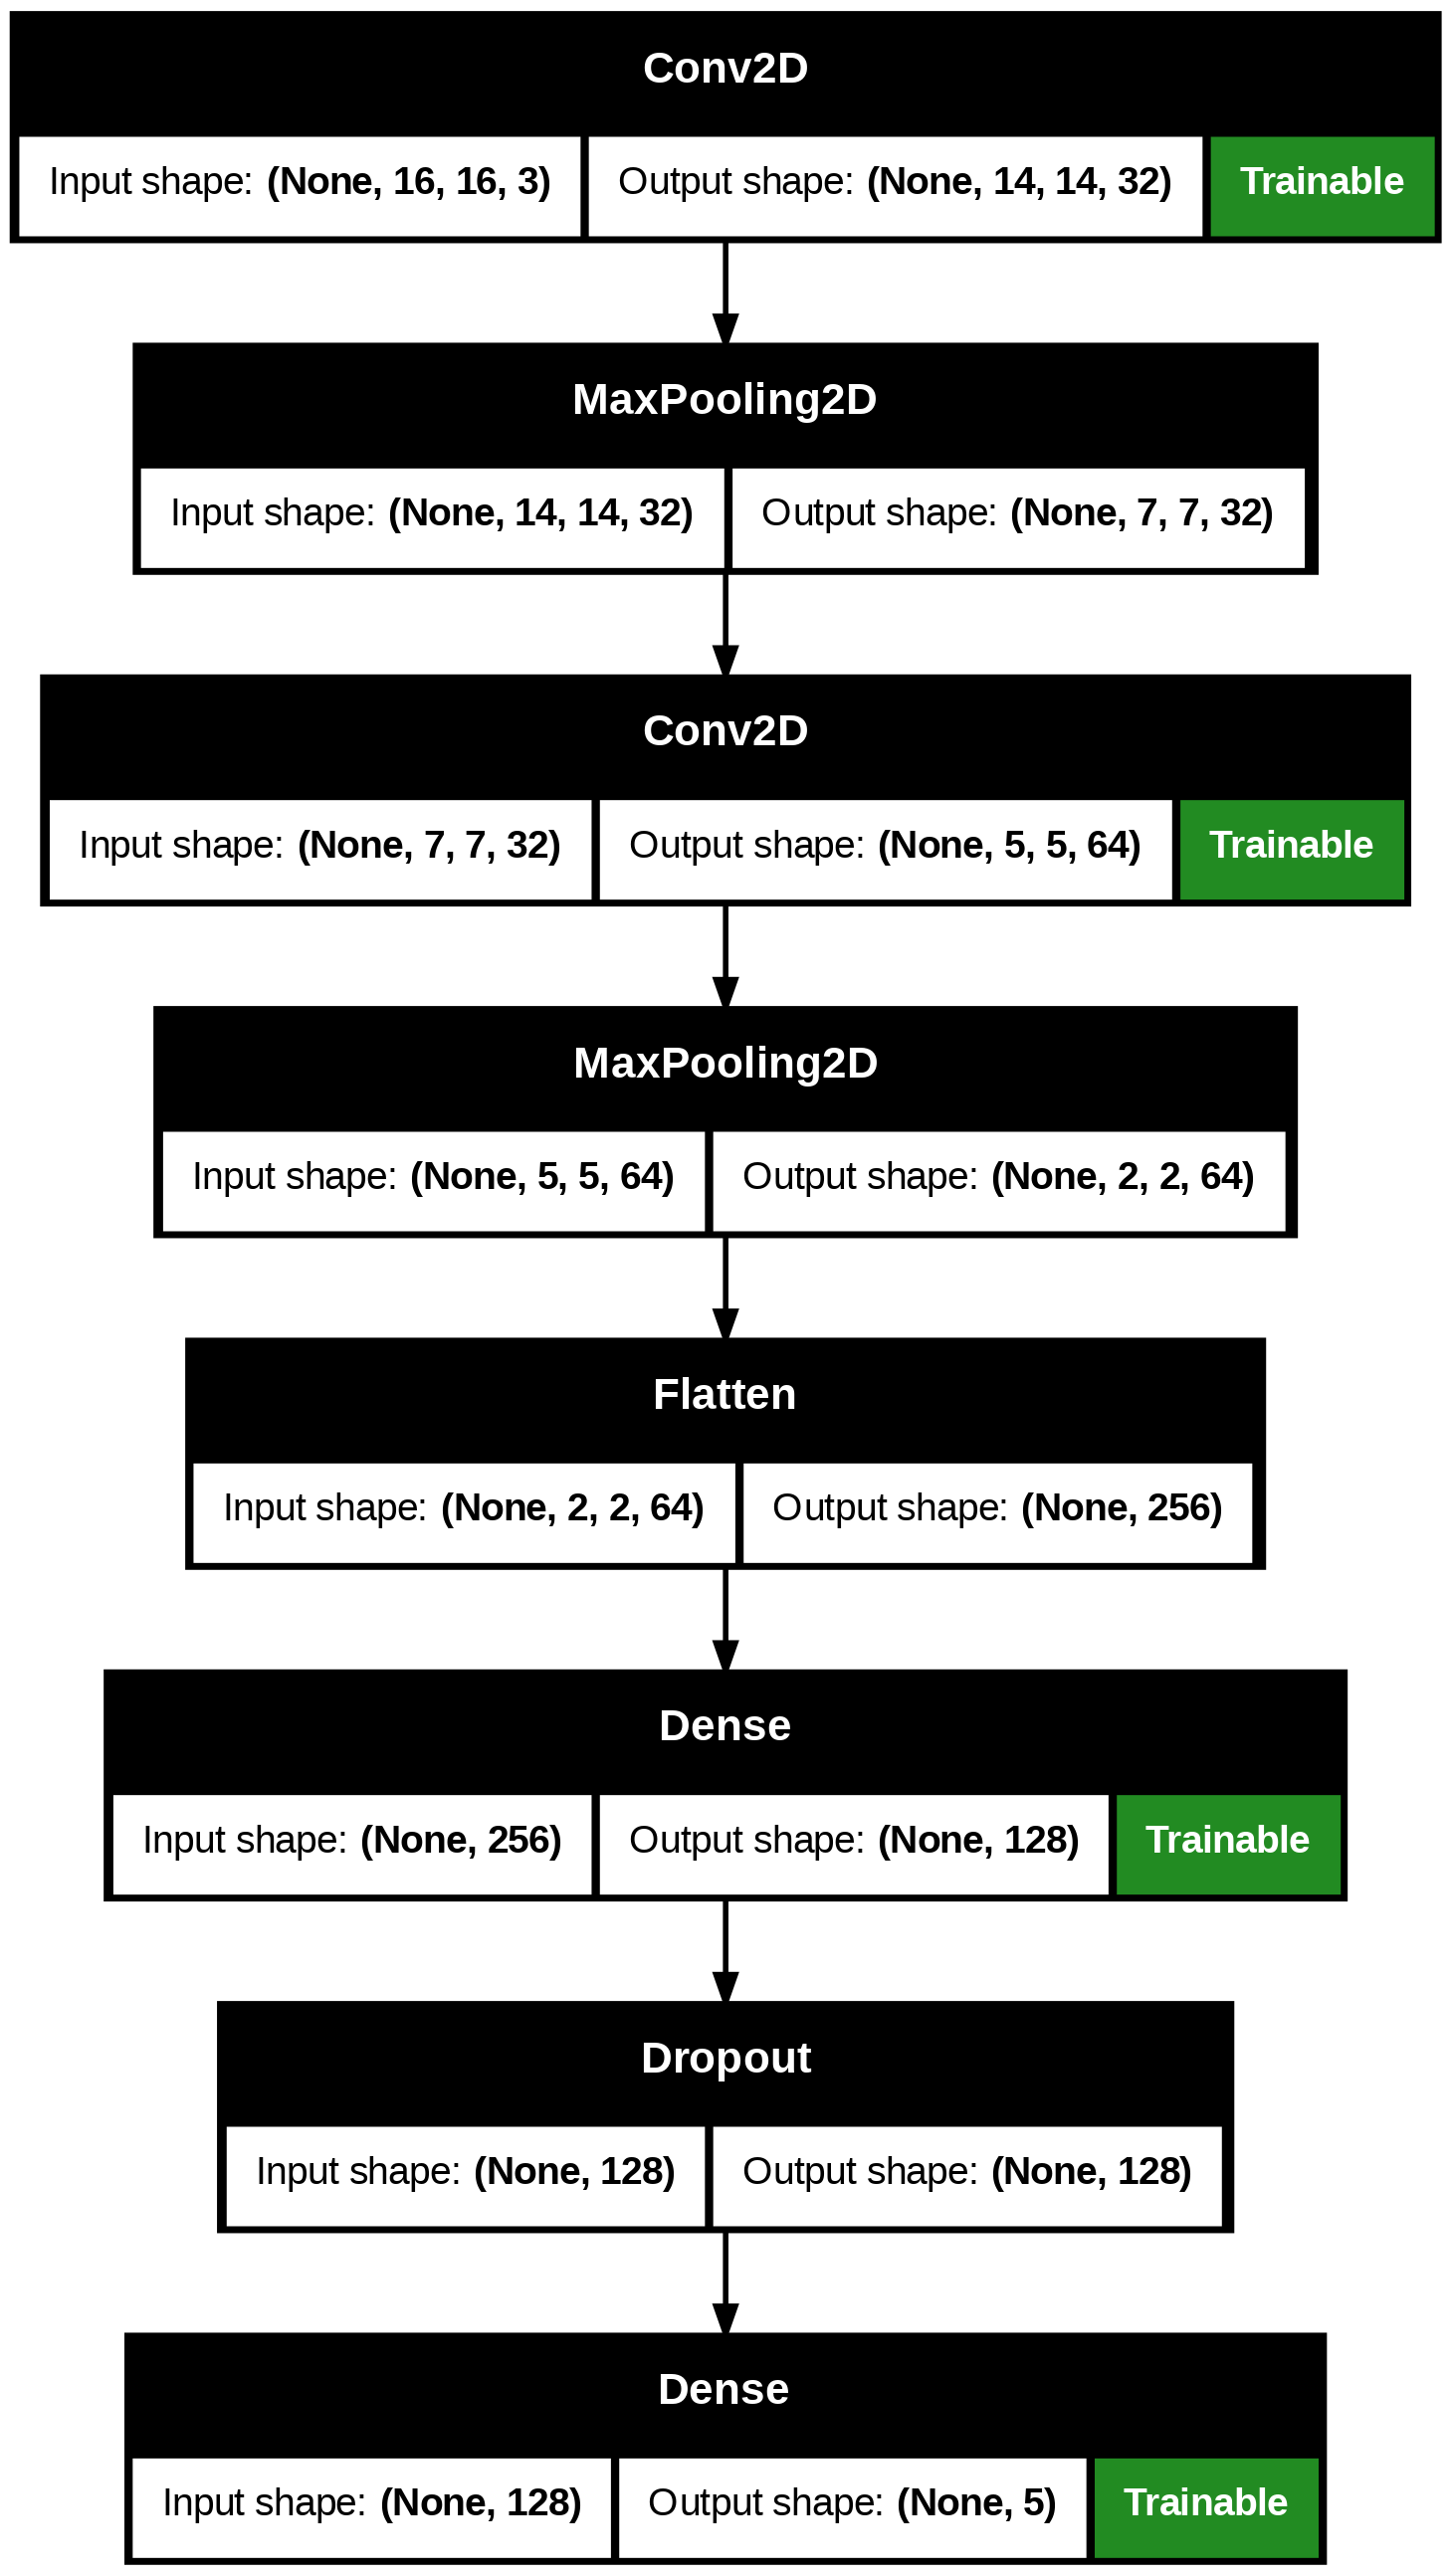

In [ ]:
model = Sequential([
    Input(shape=(16, 16, 3)),

    # First Conv Layer
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Conv Layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output
    Flatten(),

    # Dense layer with dropout to avoid overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer with softmax
    Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Suponiendo que tu modelo es el 'model'
plot_model(model, to_file='model.png', show_shapes=True, show_trainable=True)
Image('model.png', width=450)



Entrenamiento del modelo:

In [ ]:
callback = EarlyStopping(monitor = 'loss', patience=3)

history = model.fit(X_train, y_train, epochs=10, validation_split=0.25, callbacks = [callback])


Epoch 1/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8260 - loss: 0.4594 - val_accuracy: 1.0000 - val_loss: 7.9641e-04
Epoch 2/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9990 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 5.8698e-05
Epoch 3/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 2.4395e-05
Epoch 4/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 4.7263e-06
Epoch 5/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 7.5027e-05 - val_accuracy: 1.0000 - val_loss: 9.2501e-07
Epoch 6/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 6.3587e-05 - val_accuracy: 1.0000 - val_loss: 3.2165e-07
Epoch 7/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 3.9004e-05
Epoch 8/10
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluación del modelo:

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 9.6656e-08
Precisión en el conjunto de prueba: 1.0. Pérdida: 9.400145017934847e-08


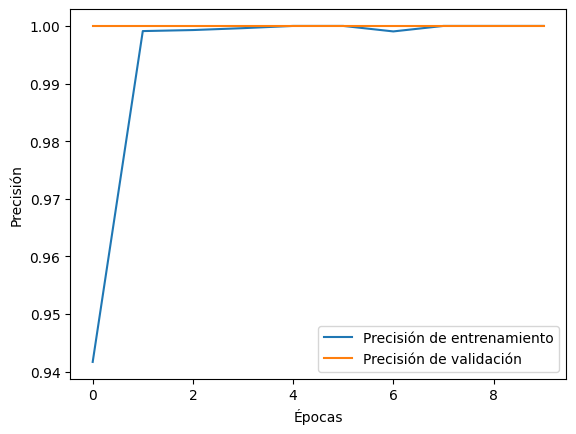

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}. Pérdida: {test_loss}')

# Visualización de los resultados
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

Métricas alternativas:

In [ ]:
from sklearn import metrics
import numpy as np

# Realizar predicciones
predict = model.predict(X_test)

# No necesitamos un umbral en este caso, ya que estamos trabajando con softmax
# y la predicción será la clase con mayor probabilidad
predict_classes = np.argmax(predict, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Predicción en el conjunto de entrenamiento
Y_pred_train = np.argmax(model.predict(X_train), axis=1)
y_train_classes = np.argmax(y_train, axis=1)

# Calcular las métricas
print('Precision (Precisión): \t', np.round(metrics.precision_score(y_train_classes, Y_pred_train, average='macro')*100, 2))
print('Accuracy (Exactitud): \t', np.round(metrics.accuracy_score(y_train_classes, Y_pred_train)*100, 2))
print('Recall (Sensibilidad): \t', np.round(metrics.recall_score(y_train_classes, Y_pred_train, average='macro')*100, 2))
print('F1 score: \t\t', np.round(metrics.f1_score(y_train_classes, Y_pred_train, average='macro')*100, 2))

# El AUC no es directamente aplicable en multiclase sin convertir a binario
# Usamos el promedio 'macro' para calcular el AUC en multiclase
y_train_prob = model.predict(X_train)  # Predicciones de probabilidad
print('AUC (Área Bajo Curva):\t', np.round(metrics.roc_auc_score(y_train, y_train_prob, multi_class='ovo', average='macro')*100, 2))


1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Precision (Precisión): 	 100.0
Accuracy (Exactitud): 	 100.0
Recall (Sensibilidad): 	 100.0
F1 score: 		 100.0
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC (Área Bajo Curva):	 100.0
